Import libraries and MNIST dataset

In [1]:
# Includes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

import numpy as np

# Load dataset
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes from MNIST are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

2022-09-10 00:39:05.811260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The original dataset shapes from MNIST are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


Regroup data in low digits (0...5) and high (6..9)

In [2]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]
img_rows, img_cols = 28, 28

trainLow_samples = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples  = np.sum(np.where(label_test  < 6, 1, 0))

# separate in containers data that is lower and higer than 6
# TRAIN - LOW
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
#       - HIGH
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

# TEST - LOW
data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)

#      - HIGH
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1


j,k = 0,0
for i in range(0,test_samples):
    if(label_test[i]>5):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1  
    else:
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1

# Reshape
data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# Print
print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

# Normalize the colors from 0-255 to 0-1
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28, 1)
     Train dataset higher than 6 has shape: (23983, 28, 28, 1)

     Test dataset lower than 6 has shape:  (6031, 28, 28, 1)
     Test dataset higher than 6 has shape: (3969, 28, 28, 1)


Load Frozen model and features

In [3]:
features = np.loadtxt('Models/Original_model/ll_features_10.txt')
labels_features = np.loadtxt('Models/Original_model/ll_labels_features_10.txt')
labels_features = labels_features.astype(int)
model = keras.models.load_model('Models/Original_model/mnist_cnn.h5')

# Print
# model.summary()

2022-09-10 00:39:14.536203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Kmeans not using sklearn

In [80]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                #if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > self.tol:
                #    print(np.sum((current_centroid - original_centroid) / original_centroid * 100.0))
                #    optimized = False

            #if optimized:
            #    break

    def predict(self, data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

    def update(self, new_data, delta):
        for featureset in new_data:
            distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]

            if min(distances) < delta:
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)
            else:
                self.centroids[self.k] = featureset
                self.classifications[self.k] = []
                self.classifications[self.k].append(featureset)
                self.k = self.k + 1

## Fit initial dataset

In [81]:

# Fit initial dataset. First we need to extract the corresponding images from the features list

# Define initial set of features
labels_init_list = np.array([1, 2, 5, 0])
# labels_init_list = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

# Initialize features and labels arrays for 
labels_init = np.array([])
features_init = []

for i in range(0, len(features)):
      if labels_features[i] in labels_init_list:
        features_init.append(features[i,:])
        labels_init = np.append(labels_init, labels_features[i]).astype(int)


features_init = np.array(features_init)

# debug
print(features_init.shape)
print(features.shape)

# Initial fitting with n clusters 
n_clust_init = len(labels_init_list)

kmeans = K_Means(k = n_clust_init)

kmeans.fit(features_init)

# provaare aa fare predizioni e vedere se le mette nela categoria giusta

(40, 512)
(100, 512)


K means script scorporated for debugging purpose

In [67]:
# features_init[1]
print(features_init[1].shape)

(512,)


In [79]:
# Variables
k = 2
max_iter = 300
tol = 0.01







data = features_init



centroids = {}

for i in range(k):
    centroids[i] = data[i]

for i in range(max_iter):
    classifications = {}

    for i in range(k):
        classifications[i] = []

    for featureset in data:
        distances = [np.linalg.norm(featureset - centroids[centroid]) for centroid in centroids]
        classification = distances.index(min(distances))
        classifications[classification].append(featureset)

    prev_centroids = dict(centroids)

    for classification in classifications:
      centroids[classification] = np.average(classifications[classification], axis=0)

    optimized = True

    #for c in centroids:
    #    original_centroid = prev_centroids[c]
    #    current_centroid = centroids[c]
    #    if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > tol:
    #        print(np.sum((current_centroid - original_centroid) / original_centroid * 100.0))
    #        optimized = False

    if optimized:
        break


print(centroids[0].shape)

(512,)


In [ ]:




# Fit






class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, data):

        # Initialize centroids with first data incoming


    def predict(self, data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

    def update(self, new_data, delta):
        for featureset in new_data:
            distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]

            if min(distances) < delta:
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)
            else:
                self.centroids[self.k] = featureset
                self.classifications[self.k] = []
                self.classifications[self.k].append(featureset)
                self.k = self.k + 1






50.0
513.8888888888889
19.333333333333336
85.97370695537461


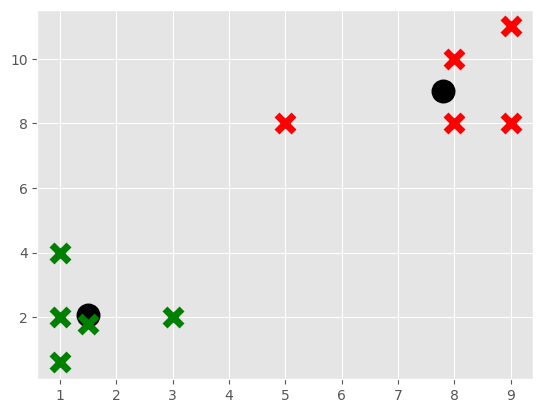

In [45]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')
colors = 10 * ["g", "r", "c", "b", "k"]

X = np.array([[1, 2],
              [1.5, 1.8],
              [5, 8],
              [8, 8],
              [8,10],
              [9,8],
              [3,2],
              [1,4],
              [1, 0.6],
              [9, 11]])

clf = K_Means(k = 2)
clf.fit(X)

X1 = np.array([[6, 8],
               [7, 10],
               [6, 4],
               [2, 2],
               [2, 3]])

#Updating the model with X1 and threshold of 4 
# clf.update(X1, 4)

for centroid in clf.centroids:
    plt.scatter(clf.centroids[centroid][0], clf.centroids[centroid][1],
                marker="o", color="k", s=150, linewidths=5)

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)

plt.show()